In [121]:
from bs4 import BeautifulSoup as BS4
import requests
import pandas as pd
import numpy as np
import seaborn as sns

In [122]:
HEADERS = {
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36",
    "Accept" : "*/*"
}

URL = 'https://auto.ria.com/uk/search/?indexName=auto&brand.id[0]=24&model.id[0]=239&country.import.usa.not=1&price.currency=1&abroad.not=0&custom.not=1&size=100'

In [123]:
def get_html(url, params = ""):
    r = requests.get(url, headers=HEADERS, params=params)
    return r

def get_content(html):
    soup = BS4(html, 'html.parser')
    items = soup.find_all('section', class_='ticket-item')
    cars = []
    
    for item in items:
        cars.append({
            "brand": item.find('div', attrs = {"class": 'hide'}).get('data-mark-name'),
            "model": item.find('div', attrs = {"class": 'hide'}).get('data-model-name'),
            "year": item.find('div', attrs = {"class": 'hide'}).get('data-year'),
            "url": item.find('a', attrs = {"class": 'address'}).get('href'),
            "price_USD": item.find('div', attrs = {"class": 'price-ticket'}).get('data-main-price'),
            "km": item.find('i', attrs = {"title": 'Пробіг'}).next_element,
            "location": item.find('i', attrs = {"class": 'icon-location'}).next_element,
            "fuel": item.find('i', attrs = {"title": 'Тип палива'}).next_element,
            "transmission": item.find('i', attrs = {"title": 'Тип коробки передач'}).next_element
        })
    
    return cars

def parser():
    PAGES = input("До какой страницы парсить? ")
    PAGES = int(PAGES.strip())+1
    html = get_html(URL)
    if html.status_code == 200:
        cars = []
        for page in range(0, PAGES):
            print(f'Парсим страницу: {page}')
            html = get_html(URL, params={'&page': page})
            cars.extend(get_content(html.text))
        return cars
    else:
        print("Ошибка получения страницы")

cars = parser()
cars_df = pd.DataFrame(cars, columns=['brand', 'model', 'year', 'url', 'price_USD', 'km', 'location', 'fuel', 'transmission'])
cars_df.head()

До какой страницы парсить? 6
Парсим страницу: 0
Парсим страницу: 1
Парсим страницу: 2
Парсим страницу: 3
Парсим страницу: 4
Парсим страницу: 5
Парсим страницу: 6


,brand,model,year,url,price_USD,km,location,fuel,transmission
0,Ford,Fiesta,2012,https://auto.ria.com/uk/auto_ford_fiesta_30603...,222000,98 тис. км,Київ,"Бензин, 1.6 л.",Автомат
1,Ford,Fiesta,2012,https://auto.ria.com/uk/auto_ford_fiesta_30523...,7500,121 тис. км,Дніпро (Дніпропетровськ),"Газ / Бензин, 1.2 л.",Ручна / Механіка
2,Ford,Fiesta,2012,https://auto.ria.com/uk/auto_ford_fiesta_30571...,8499,48 тис. км,Дніпро (Дніпропетровськ),"Бензин, 1.25 л.",Ручна / Механіка
3,Ford,Fiesta,2016,https://auto.ria.com/uk/auto_ford_fiesta_30528...,9700,77 тис. км,Одеса,"Бензин, 1.25 л.",Ручна / Механіка
4,Ford,Fiesta,2008,https://auto.ria.com/uk/auto_ford_fiesta_30461...,4400,182 тис. км,Острог,"Бензин, 1.4 л.",Не вказано


In [124]:
cars_df.to_csv("ford_cars.csv")

In [125]:
cars_df = pd.read_csv(r"c:\users\echerepenya\ford_cars.csv", encoding = 'utf8')
cars_df.drop(['Unnamed: 0','url'], axis=1, inplace=True)
cars_df.dtypes

brand           object
model           object
year             int64
price_USD        int64
km              object
location        object
fuel            object
transmission    object
dtype: object

In [126]:
cars_df = cars_df[cars_df['year'] > 2000]
cars_df['price_USD'].replace(222000, 222000/27.3, inplace = True)
cars_df[['fuel','volume']] = cars_df['fuel'].str.split(', ', 1, expand=True)
cars_df['volume'] = cars_df['volume'].str.replace(' л.', '').astype(float)
cars_df['km'] = cars_df['km'].str.replace(' тис. км', '').astype(float)
cars_df.describe()

,year,price_USD,km,volume
count,679.000000,679.000000,679.000000,630.000000
mean,2010.835052,6695.916166,130.958763,1.345444
std,3.662681,2025.527997,64.701206,0.209005
min,2002.000000,3300.000000,19.000000,1.000000
25%,2007.000000,5000.000000,93.000000,1.200000
50%,2011.000000,6500.000000,121.000000,1.400000
75%,2013.000000,8150.000000,171.000000,1.500000
max,2018.000000,12500.000000,390.000000,2.000000


In [133]:
cars_df[(cars_df['fuel'] == '1.3 л.') | (cars_df['fuel'] == '1.25 л.')]

,brand,model,year,price_USD,km,location,fuel,transmission,volume


In [129]:
cars_df['fuel'].value_counts()

 Бензин           490
 Дизель            77
 Газ / Бензин      63
 Бензин            21
 Газ / Бензин      14
 1.3 л.             7
 1.25 л.            7
Name: fuel, dtype: int64

In [106]:
cars_df.dropna()

,brand,model,year,price_USD,km,location,fuel,transmission,volume
0,Ford,Fiesta,2012,8131.868132,98.0,Київ,Бензин,Автомат,1.60
1,Ford,Fiesta,2012,7500.000000,121.0,Дніпро (Дніпропетровськ),Газ / Бензин,Ручна / Механіка,1.20
2,Ford,Fiesta,2012,8499.000000,48.0,Дніпро (Дніпропетровськ),Бензин,Ручна / Механіка,1.25
3,Ford,Fiesta,2016,9700.000000,77.0,Одеса,Бензин,Ручна / Механіка,1.25
4,Ford,Fiesta,2008,4400.000000,182.0,Острог,Бензин,Не вказано,1.40
...,...,...,...,...,...,...,...,...,...
695,Ford,Fiesta,2012,9500.000000,59.0,Харків,Бензин,Автомат,1.40
696,Ford,Fiesta,2018,8700.000000,107.0,Васильків,Бензин,Автомат,1.60
697,Ford,Fiesta,2011,8000.000000,55.0,Київ,Бензин,Ручна / Механіка,1.20
698,Ford,Fiesta,2011,7900.000000,97.0,Київ,Газ / Бензин,Автомат,1.40


In [107]:
cars_df[cars_df.volume.isnull()]

,brand,model,year,price_USD,km,location,fuel,transmission,volume
10,Ford,Fiesta,2015,8000.0,58.0,Кам'янське (Дніпродзержинськ),Бензин,Ручна / Механіка,NaN
52,Ford,Fiesta,2012,5600.0,200.0,Ковель,1.3 л.,Ручна / Механіка,NaN
55,Ford,Fiesta,2007,3950.0,230.0,Київ,Бензин,Робот,NaN
74,Ford,Fiesta,2006,4000.0,260.0,Бердянськ,1.25 л.,Ручна / Механіка,NaN
83,Ford,Fiesta,2008,5500.0,130.0,Біла Церква,Газ / Бензин,Автомат,NaN
86,Ford,Fiesta,2011,5350.0,151.0,Івано-Франківськ,Бензин,Ручна / Механіка,NaN
92,Ford,Fiesta,2007,4800.0,390.0,Біла Церква,Газ / Бензин,Ручна / Механіка,NaN
110,Ford,Fiesta,2015,8000.0,58.0,Кам'янське (Дніпродзержинськ),Бензин,Ручна / Механіка,NaN
152,Ford,Fiesta,2012,5600.0,200.0,Ковель,1.3 л.,Ручна / Механіка,NaN
156,Ford,Fiesta,2007,3950.0,230.0,Київ,Бензин,Робот,NaN


<AxesSubplot:xlabel='km', ylabel='price_USD'>

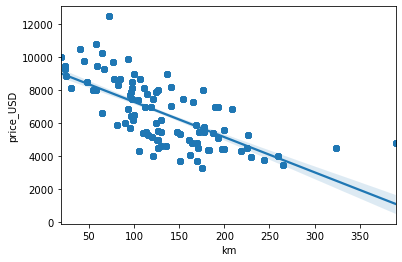

In [77]:
sns.regplot(x='km', y='price_USD', data=cars_df)

In [170]:
#cars_df[cars_df['price_USD'] == '235000']
cars_df[cars_df['location'] == 'Київ'].value_counts()
#cars_df['location'].replace('Дніпро (Дніпропетровськ)', 'Дніпро', inplace = True)
#cars_df['location'].value_counts().to_frame()

Series([], dtype: int64)

In [63]:
cars_df.km = cars_df.km.str.replace(' тис. км', '')
cars_df.manufacture_year = cars_df.manufacture_year.astype(float)
cars_df.km = cars_df.km.astype(float)
cars_df.price_USD = cars_df.price_USD.astype(float)
cars_df.dtypes

brand                object
model                object
manufacture_year    float64
url                  object
price_USD           float64
km                  float64
location             object
fuel                 object
transmission         object
dtype: object

In [64]:
cars_df.head()

,brand,model,manufacture_year,url,price_USD,km,location,fuel,transmission
0,Ford,Fiesta,2012.0,https://auto.ria.com/uk/auto_ford_fiesta_30603...,235000.0,98.0,Київ,"Бензин, 1.6 л.",Автомат
1,Ford,Fiesta,2012.0,https://auto.ria.com/uk/auto_ford_fiesta_30523...,7500.0,121.0,Дніпро (Дніпропетровськ),"Газ / Бензин, 1.2 л.",Ручна / Механіка
2,Ford,Fiesta,2012.0,https://auto.ria.com/uk/auto_ford_fiesta_30571...,8499.0,48.0,Дніпро (Дніпропетровськ),"Бензин, 1.25 л.",Ручна / Механіка
3,Ford,Fiesta,2012.0,https://auto.ria.com/uk/auto_ford_fiesta_30607...,5500.0,113.0,Одеса,"Бензин, 1.2 л.",Ручна / Механіка
4,Ford,Fiesta,2011.0,https://auto.ria.com/uk/auto_ford_fiesta_30179...,7800.0,114.0,Дніпро (Дніпропетровськ),"Бензин, 1.4 л.",Автомат


In [104]:
cars_df.price_USD.replace(235000, 235000/27.3, inplace=True)
cars_df.describe()

,manufacture_year,price_USD,km
count,81.000000,81.000000,81.000000
mean,2011.493827,7250.482205,126.358025
std,0.503077,1342.995408,46.688946
min,2011.000000,3500.000000,31.000000
25%,2011.000000,6450.000000,97.000000
50%,2011.000000,7000.000000,123.000000
75%,2012.000000,8000.000000,151.000000
max,2012.000000,11500.000000,257.000000


In [95]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(cars_df.price_USD))
print(z)
print(np.where(z>3))
print(cars_df.price_USD[22])

[1.01715531 0.18694959 0.93544385 1.31153743 0.41172264 0.78634439
 1.23661308 0.52483174 0.59975609 1.31153743 1.01184002 0.16144864
 1.42392395 1.6854366  0.56157134 0.48664699 0.63721827 0.18842141
 0.71214262 0.59975609 1.8352853  0.56229392 3.18392362 0.41172264
 0.52483174 0.18694959 0.56229392 0.86126874 0.33827011 1.46066355
 0.26187394 0.11274782 1.46066355 0.52483174 0.56229392 0.03782346
 1.08676437 0.03782346 0.59975609 0.22513434 0.56229392 0.93619309
 0.41172264 0.18767217 1.01184002 0.56304316 0.93619309 1.01111745
 0.93691567 1.0860418  0.14948741 0.93691567 2.81002444 0.44990739
 0.18694959 0.71142004 1.23661308 0.33752087 0.03782346 0.93619309
 1.31153743 0.18694959 0.56229392 0.71214262 0.56157134 1.5355879
 0.18767217 1.31153743 0.7496048  0.56229392 0.33679829 0.56229392
 0.41172264 2.06005836 0.56157134 1.8352853  1.01111745 0.71214262
 0.56229392 1.38646178 1.98513401]
(array([22], dtype=int64),)
11500.0


In [103]:
Q1 = cars_df.quantile(0.25)
Q3 = cars_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
cars_df_filtered = cars_df[~(((cars_df < (Q1 - 1.5 * IQR)) | (cars_df > (Q3 + 1.5 * IQR))).any(axis = 1))]
cars_df_filtered.describe()

manufacture_year       1.0
price_USD           1550.0
km                    54.0
dtype: float64


,manufacture_year,price_USD,km
count,76.000000,76.000000,76.000000
mean,2011.513158,7277.487613,122.526316
std,0.503148,1210.625342,40.318556
min,2011.000000,5350.000000,31.000000
25%,2011.000000,6486.750000,96.500000
50%,2012.000000,7067.500000,122.000000
75%,2012.000000,8050.000000,146.250000
max,2012.000000,10000.000000,224.000000


<AxesSubplot:ylabel='price_USD'>

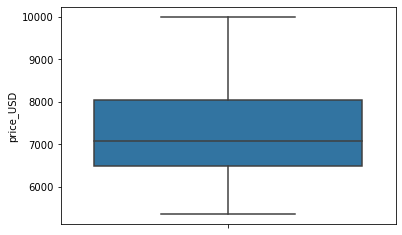

In [106]:
sns.boxplot(y=cars_df_filtered['price_USD'])

<AxesSubplot:xlabel='km', ylabel='price_USD'>

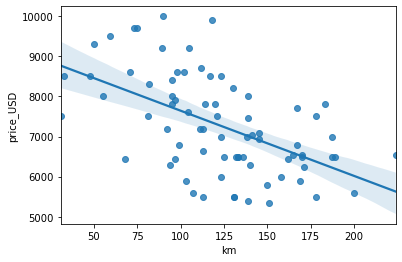

In [113]:
sns.regplot(x="km", y="price_USD", data=cars_df_filtered)

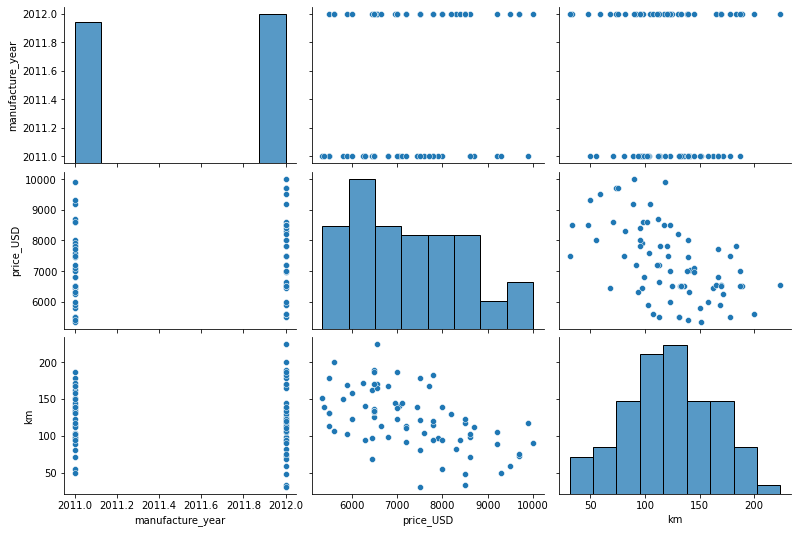

In [116]:
sns.pairplot(cars_df_filtered, aspect = 1.5)